# 1.MORO OPTIMIZATION

# 1.1 Generate random policies

In [1]:
from ema_workbench import (Model, RealParameter, Policy, Scenario, ScalarOutcome)
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from problem_formulation import get_model_for_problem_formulation
##Paralel computing
from ema_workbench import (MultiprocessingEvaluator, ema_logging,
                           perform_experiments)
import numpy as np
import pandas as pd
import seaborn as sns

# With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, 
# directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

%matplotlib inline

ema_logging.log_to_stderr(ema_logging.INFO)

'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''

dike_model, planning_steps = get_model_for_problem_formulation(1) # assign problem_formulation_id

C:\Users\georg\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\georg\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [7]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'

Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 0.000001) #not ok
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 1000) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Total_Investment_Costs = functools.partial(robustness, SMALLER, 150000000)#THOSE NUMBERS NEED TO BE SPECIFIED AGAINS


robustness_funcs = {"Expected Number of Deaths": Expected_Number_of_Deaths,
                    "Expected Annual Damage": Expected_Annual_Damage,
                    "Total Investment Costs": Total_Investment_Costs}


In [12]:
%%time 
from ema_workbench import ema_logging, MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=200,               #500
                                            policies=4,
                                            uncertainty_sampling='mc')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 200 scenarios * 4 policies * 1 model(s) = 800 experiments
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 320 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 560 cases completed
[MainProcess/INFO] 640 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Wall time: 23min 11s


In [13]:
save_results(results, "OptimizationMoro200scen4pol.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\OptimizationMoro200scen4pol.tar.gz


In [25]:
results = load_results(".\OptimizationMoro200scen4pol.tar.gz")
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\OptimizationMoro200scen4pol.tar.gz


In [29]:
np.unique(experiments['policy'])

array([0, 1, 2, 3], dtype=int64)

NameError: name 'results' is not defined

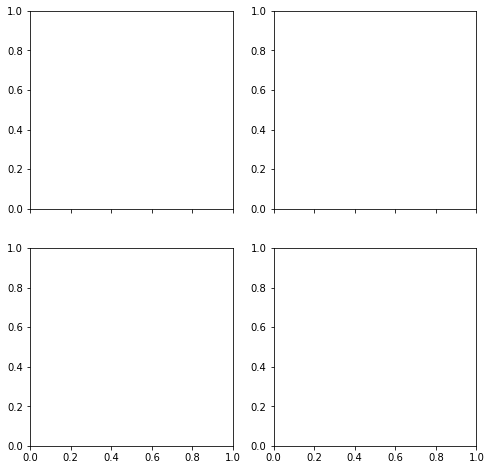

In [6]:
### Very nice script to create the visualization of how the robustness evolves over time for each policy

import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]                             #axes[1,1]

robustness_funcs = {"Expected Number of Deaths": Expected_Number_of_Deaths,
                    "Expected Annual Damage": Expected_Annual_Damage,
                    "Total Investment Costs": Total_Investment_Costs}

experiments, outcomes = results

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

# 1.2 Search for candidate solutions

the fundamental problem is fine tuning the robustness functions. To do this, rather than run optimizaitons many times, why not first generate a test set with a bunch of policies, apply robustness functions and visualize the results?

This gives us much faster feedback on reasonble cutoff values. 


In [3]:
from ema_workbench.em_framework import sample_uncertainties

n_scenarios = 3
scenarios = sample_uncertainties(dike_model, n_scenarios)
nfe = 400

In [38]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenarios,              
                                            policies=100)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10 scenarios * 100 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Wall time: 11min 26s


In [40]:
save_results(results, "OptimizationMoro10scen100pol.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\OptimizationMoro10scen100pol.tar.gz


In [53]:
results = load_results(".\OptimizationMoro10scen100pol.tar.gz")
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\OptimizationMoro10scen100pol.tar.gz


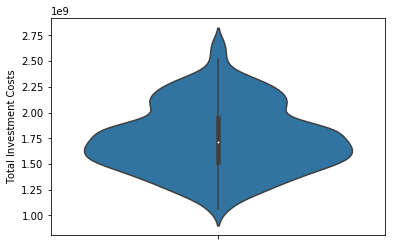

In [47]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(data=data, y='Total Investment Costs')
plt.show()

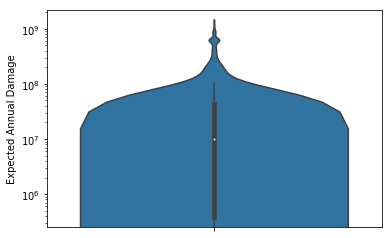

In [48]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Annual Damage')
ax.set_yscale('log')
plt.show()

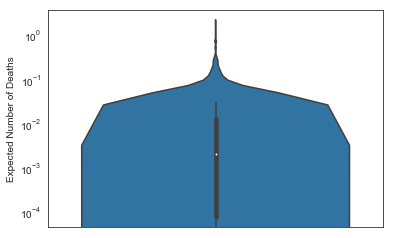

In [52]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Number of Deaths')
ax.set_yscale('log')
plt.show()

In [50]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'

Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 1e-5) #not ok
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 1e4) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Total_Investment_Costs = functools.partial(robustness, SMALLER, 6e8)#THOSE NUMBERS NEED TO BE SPECIFIED AGAINS


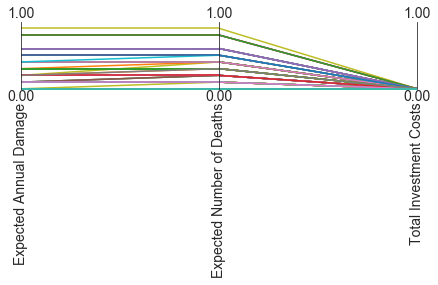

In [54]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [ ]:
from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

BaseEvaluator.reporting_frequency = 0.1

# ema_logging.log_to_stderr(ema_logging.INFO)

# there is a bit of problem with platypus, so using 1.1. gives 
# cleaner hypervolume results.
convergence_metrics = [HyperVolume(minimum=[0,0,0], maximum=[1.1, 1.1, 1.1]),
              EpsilonProgress()]

epsilons=[0.05,0.05,0.05]  #final value of epsilon should be much lower.Just for experiment purposes is 1
with MultiprocessingEvaluator(dike_model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustness_funcs, scenarios,nfe=nfe,
                                                     convergence=convergence_metrics, epsilons=epsilons)
    
#start = time.time()
#end = time.time()

#print('Processing time:',(end-start)/60,'Minutes')    

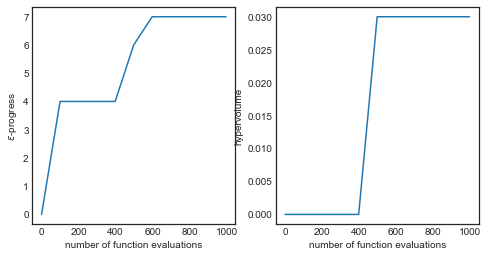

In [61]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

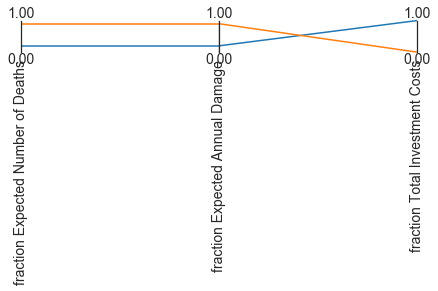

In [62]:
from ema_workbench.analysis import parcoords

data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

This is a bit better but not much. 

Now, observe the following: you are using a domain criterion as your sole measure of robustness. That is, you look at the fraction of scenarios above or below a threshold. The costs however do not vary accross scenarios. Thus this objective can only be 0 or 1. This is not particularly useful for optimization. 

We might thus want to consider another metric for costs. Why not simply use the raw costs itself?


In [63]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def costs(data):
    return data[0]/1e9 # makes numbers nicer
    
SMALLER = 'SMALLER'

Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 1e-5) #not ok
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 1e4) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Total_Investment_Costs = costs


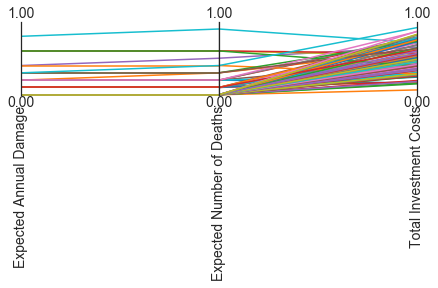

In [64]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

This already looks much nicer.

In [67]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

robustnes_functions = [ScalarOutcome('fraction EA deaths', kind=MAXIMIZE, 
                             variable_name='Expected Number of Deaths', function=Expected_Number_of_Deaths),
                       ScalarOutcome('fraction EA damage', kind=MAXIMIZE, 
                             variable_name='Expected Annual Damage', function=Expected_Annual_Damage),
                       ScalarOutcome('investment costs', kind=MINIMIZE, # note that we have to minimize costs!
                             variable_name='Total Investment Costs', function=Total_Investment_Costs)]

In [68]:
# we have to change the plausible max for total investment costs
convergence = [HyperVolume(minimum=[0,0,0], maximum=[1.1, 1.1, 3]),
              EpsilonProgress()]

epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
with MultiprocessingEvaluator(model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe,
                                                     convergence=convergence, epsilons=epsilons)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] performing 10 scenarios * 100 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/1000 nfe
[MainProcess/INFO] performing 10 scenarios * 100 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/1000 nfe
[MainProcess/INFO] performing 10 scenarios * 100 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 300/1000 nfe
[MainProcess/INFO] performing 10 scenarios * 100 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 4: 400/1000 nfe
[MainProcess/INFO] performing 10 scenarios * 100 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 5: 500/1000 nfe
[MainProcess/INFO] performing 10 scenarios *

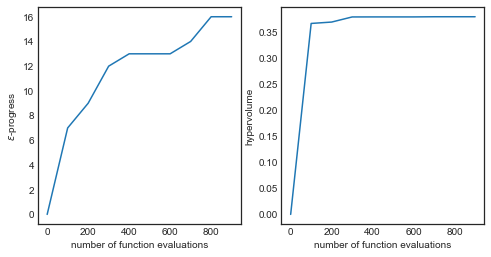

In [69]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

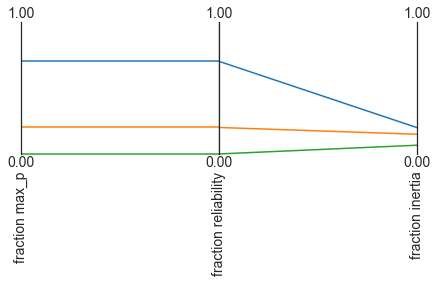

In [70]:
data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

# 1.3 Re-evaluate candidate solutions under uncertainty

In [30]:
from ema_workbench import Policy

policies = archive.drop([o.name for o in robustnes_functions], axis=1)
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy("moro {}".format(i), **policy.to_dict()))

In [31]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

#start = time.time()
#end = time.time()

#print('Processing time:',(end-start)/60,'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [32]:
from ema_workbench import save_results

save_results(results, 'MORO_reevaluation.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\anton\Desktop\EPAMasterprogram\4thquarter\Model-based Decision-Making\Assignments-11-06-2018\epa1361_open-master\final assignment\MORO_reevaluation.tar.gz


In [33]:
policies.to_csv('moro polices.csv')

In [34]:
import pandas as pd
experiments, outcomes = results

overall_robustness = {}
for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness

,Expected Annual Damage,Expected Number of Deaths,Total Investment Costs
moro 0,0.96,0.96,0.0


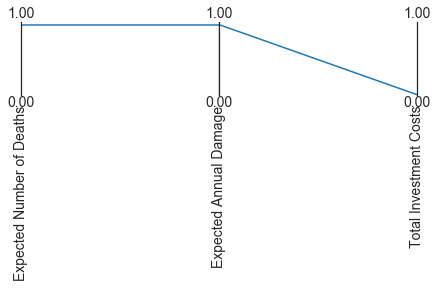

In [35]:

data = overall_robustness.loc[:, 
                              ['Expected Number of Deaths', 'Expected Annual Damage', 'Total Investment Costs']]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()